In [1]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:
import pickle
import clip
import socket
import numpy as np
import torch
from utils import nethook

%reload_ext autoreload
%autoreload 2

print("Hostname: " + socket.gethostname())
print("Torch version:", torch.__version__)
torch.cuda.empty_cache()

Hostname: sx-el-121920
Torch version: 1.13.0a0+d0d6b1f


In [3]:
# general configuration
ROOT_PATH = "/mnt/data/patrick.koller/masterthesis/data"

# simplify problem
USE_ALL_STANDALONE_LAYERS = True
USE_ALL_CLIP_LAYERS = False
LIMIT_NR_LAYERS = 100 # Active, if all layers are used with the configurations above = True

# dataset parameters
DATASET_BATCH_SIZE = 10
DATASET_SHUFFLE = True
DATASET_TEST_FOOL_RANDOM_COLORS = True

# set device (for number crunching)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# load standalone model

In [5]:
def setup_standalone(all_layers=True, all_layers_limit=100, print_config=False):

    # load model
    standalone_model = pickle.load(open(f"{ROOT_PATH}/results/standalone_resnet50_biased.mdl", 'rb'))
    standalone_model.cuda()

    # make sure that all standalone resnet50 parameters are floating point variables (paranoia)
    for p in standalone_model.parameters(): 
        p.data = p.data.float()  
        
    # save layers to be swapped
    if all_layers:
        standalone_layers = []
        counter = 0

        for name, layer in standalone_model.named_modules():
            if "conv" in name and counter < all_layers_limit:
                standalone_layers.append(name)
                counter += 1
        # or
        # clip_layers = [ "model.layer1", "model.layer2", "model.layer3", "model.layer4"]
        del counter
    else:
        standalone_layers = ['layer1.0.conv1', 'layer1.0.conv2']
        # standalone_layers = ['layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.1.conv1', 'layer1.1.conv2']
        
    # additional info
    if print_config:       
        print(f"Number of standalone layers: {len(standalone_layers)}")
        print(standalone_layers)

    # hook layers for standalone model
    standalone_model.eval()
    standalone_model = nethook.InstrumentedModel(standalone_model)
    standalone_model.retain_layers(standalone_layers)

    return standalone_model, standalone_layers

standalone_model, standalone_layers = setup_standalone(USE_ALL_STANDALONE_LAYERS, LIMIT_NR_LAYERS, print_config=True)

Number of standalone layers: 49
['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.1.conv1', 'layer1.1.conv2', 'layer1.1.conv3', 'layer1.2.conv1', 'layer1.2.conv2', 'layer1.2.conv3', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.conv3', 'layer2.1.conv1', 'layer2.1.conv2', 'layer2.1.conv3', 'layer2.2.conv1', 'layer2.2.conv2', 'layer2.2.conv3', 'layer2.3.conv1', 'layer2.3.conv2', 'layer2.3.conv3', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.conv3', 'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3', 'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3', 'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3', 'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3', 'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3', 'layer4.1.conv1', 'layer4.1.conv2', 'layer4.1.conv3', 'layer4.2.conv1', 'layer4.2.conv2', 'layer4.2.conv3']


# load CLIP model

In [6]:
def setup_clip(all_layers=True, all_layers_limit=100, print_config=False):
    
    # load model
    clip_model, clip_preprocess = clip.load("RN50")
    clip_model.cuda().eval()

    # make sure that all clip parameters are floating point variables (paranoia)
    for p in clip_model.parameters(): 
        p.data = p.data.float() 
        
    # save layers to be swapped
    if all_layers:
        clip_layers = []
        counter = 0

        for name, layer in clip_model.named_modules():
            if "conv" in name and counter < all_layers_limit:
                clip_layers.append(name)
                counter += 1
        # or
        # clip_layers = [ "visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
        del counter
    else:
        clip_layers = ["visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
        # clip_layers = ['visual.layer1.0.conv1', 'visual.layer1.0.conv2', 'visual.layer1.0.conv3']
        # clip_layers = ['visual.layer1.0.conv1', 'visual.layer1.0.conv2', 'visual.layer1.0.conv3', 'visual.layer1.1.conv1', 'visual.layer1.1.conv2', 'visual.layer1.1.conv3']
    
    # additional info
    if print_config:       
        print(f"Number of CLIP layers: {len(clip_layers)}")
        print(clip_layers)

    # hook layers for clip model
    clip_model.eval()
    clip_model = nethook.InstrumentedModel(clip_model)
    clip_model.retain_layers(clip_layers)
    
    return clip_model, clip_preprocess, clip_layers

clip_model, clip_preprocess, clip_layers = setup_clip(USE_ALL_CLIP_LAYERS, LIMIT_NR_LAYERS, print_config=True)

Number of CLIP layers: 4
['visual.layer1', 'visual.layer2', 'visual.layer3', 'visual.layer4']


# load datasets

In [7]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

In [8]:
from torchvision import transforms

# initialize dataset
data_set = DatasetMNIST(root=ROOT_PATH,
                        env='test',
                        color=True,
                        opt_postfix="2classes",
                        filter=[5,8],
                        first_color_max_nr=5,
                        preprocess=clip_preprocess,
                        test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                        transform= transforms.Compose([transforms.ToTensor()]))

# create dataloaders
data_loader = torch.utils.data.DataLoader(dataset=data_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

if False:
    print(f"Number of samples: {len(data_loader.dataset.data_label_tuples)}")
    digit_distribution(data_set)
    plot_digits(data_set, clip_preprocess)

MNIST dataset already exists


# compute statistics

In [9]:
from torchvision import transforms

def get_mean_std(standalone_model, standalone_layers, clip_model, clip_layers, dataloader, batch_size, device):
    print("Collecting Dataset Statistics")
    
    standalone_model_stats_list = []
    clip_model_stats_list = []
    
    # batch processing
    with torch.no_grad():
        for iteration, data in enumerate(dataloader):
            
            # copy data to GPU
            inputs, _, _, _ = data
            inputs = inputs.to(device)
            
            print(f"Batch {iteration} is being processed...")
            
            ###############################################################################
            # Compute activations and statistics for standalone model
            ###############################################################################
            
            # inference
            _ = standalone_model(inputs)

            # store activations from current batch
            standalone_model_activations = {}
            for layer in standalone_layers:
                standalone_model_activations[layer] = []    
                standalone_model_activation = standalone_model.retained_layer(layer, clear = True)
                standalone_model_activations[layer].append(standalone_model_activation)
            
            # compute statistics (mean and standard deviation)
            batch_standalone_model_stats_list = []
            for layer in standalone_layers:
                standalone_model_activations[layer] = torch.cat(standalone_model_activations[layer], 0) # images x channels x m x m
                standalone_model_activations[layer] = torch.permute(standalone_model_activations[layer], (1,0,2,3)).contiguous() # channels x images x m x m
                standalone_model_activations[layer] = standalone_model_activations[layer].view(standalone_model_activations[layer].shape[0], -1) 
                batch_standalone_model_stats_list.append([torch.mean(standalone_model_activations[layer],dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(standalone_model_activations[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])

            # cleanup
            del standalone_model_activations
            standalone_model_stats_list.append(batch_standalone_model_stats_list)

            ###############################################################################
            # Compute activations and statistics for clip model
            ###############################################################################

            # inference
            _ = clip_model.model.encode_image(inputs)

            # store activations from current batch
            clip_model_activations = {}
            for layer in clip_layers:
                clip_model_activations[layer] = []    
                clip_model_activation = clip_model.retained_layer(layer, clear = True)
                clip_model_activations[layer].append(clip_model_activation)

            # compute statistics (mean and standard deviation)
            batch_clip_model_stats_list = []
            clip_model_stats_list.append(batch_clip_model_stats_list)
            for layer in clip_layers:
                clip_model_activations[layer] = torch.cat(clip_model_activations[layer], 0)
                clip_model_activations[layer] = torch.permute(clip_model_activations[layer], (1,0,2,3)).contiguous()
                clip_model_activations[layer] = clip_model_activations[layer].view(clip_model_activations[layer].shape[0], -1)
                batch_clip_model_stats_list.append([torch.mean(clip_model_activations[layer], dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(clip_model_activations[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])

            # cleanup
            del clip_model_activations
            torch.cuda.empty_cache()
            
        print("Done Iteration for Stats")

        ###############################################################################
        # All batches processed, create final statistics
        ###############################################################################
        # compute final stats for standalone model
        final_standalone_model_stats_list = []

        for iii in range(len(batch_standalone_model_stats_list)):
            means = torch.zeros_like(batch_standalone_model_stats_list[iii][0])
            stds = torch.zeros_like(batch_standalone_model_stats_list[iii][1])
            for jjj in range((iteration+1)):
                means+=standalone_model_stats_list[jjj][iii][0]
                stds+=standalone_model_stats_list[jjj][iii][1]**2

            final_standalone_model_stats_list.append([means/(iteration+1), torch.sqrt(stds/(iteration+1))])
        
        # compute final stats for clip model
        final_clip_model_stats_list = []

        for iii in range(len(batch_clip_model_stats_list)):
            means = torch.zeros_like(batch_clip_model_stats_list[iii][0])
            stds = torch.zeros_like(batch_clip_model_stats_list[iii][1])
            for jjj in range((iteration+1)):
                means+=clip_model_stats_list[jjj][iii][0]
                stds+=clip_model_stats_list[jjj][iii][1]**2

            final_clip_model_stats_list.append([means/(iteration+1), torch.sqrt(stds/(iteration+1))])

    return final_standalone_model_stats_list, final_clip_model_stats_list

In [10]:
def save_array(array, filename):
    """
    Save array to disk.
    """
    open_file = open(filename, "wb")
    pickle.dump(array, open_file)
    open_file.close()

In [11]:
def store_activs(model, layers):
    """
    Create list of retained activations for each layer.
    """
    activs = []
    for layer in layers:
        activation = model.retained_layer(layer, clear = True)
        activs.append(activation)
        
    return activs

In [12]:
def dict_layers(activs):
    """
    Create dictionary with activations of a layer as keys and the number of kernels in this layer as values.
    """
    all_layers = {}
    for iii, activ in enumerate(activs):
        all_layers[activs[iii]] = activ.shape[1]
    return all_layers

In [13]:
def normalize(activation, stats_table):
    """
    Normalize activations using standard scaling.
    """
    eps = 0.00001
    norm_input = (activation- stats_table[0])/(stats_table[1]+eps)
    
    return norm_input

In [14]:
def create_final_table(all_match_table, standalone_dict, clip_dict, batch_size, device ):
    """
    "Flatten" 4D-tensor all_match_table to large 2D-tensor final_match_table
    for better indexing and usability.
    """
    
    # create empty table of size: "number of convolution kernels in standalone_dict" x "number of convolution kernels in clip_dict"
    num_activs_standalone = sum(standalone_dict.values())
    num_activs_clip = sum(clip_dict.values())
    final_match_table = torch.zeros((num_activs_standalone, num_activs_clip)).to(device)
    
    # "flatten" 4D-tensor to large 2D-tensor
    standalone_activ_count = 0 
    for ii in range(len(all_match_table)):
        clip_activ_count = 0
        for jj in range(len(all_match_table[ii])):
            num_standalone_activs = all_match_table[ii][0].shape[0]
            num_clip_activs = all_match_table[0][jj].shape[1]
            final_match_table[standalone_activ_count: standalone_activ_count + num_standalone_activs, \
                clip_activ_count:clip_activ_count + num_clip_activs] = all_match_table[ii][jj]
            clip_activ_count += num_clip_activs
        standalone_activ_count += num_standalone_activs
    return final_match_table

# activation matching

In [15]:
from utils import matching, nethook, stats

def activation_matching(standalone_model, standalone_layers, clip_model, clip_layers, dataloader, batch_size, save_path, device):
    
    # compute dataset statistics
    standalone_model_statistics_table, clip_model_statistics_table = get_mean_std(standalone_model, standalone_layers, clip_model, clip_layers, dataloader, batch_size, device)
    save_array(standalone_model_statistics_table, f"{save_path}/standalone_model_statistics.pkl")
    save_array(clip_model_statistics_table, f"{save_path}/clip_model_statistics.pkl")
    
    print("Done")
    print("Starting Activation Matching")
    
    for iteration, data in enumerate(dataloader):
        with torch.no_grad():

            # copy data to GPU
            inputs, _, _, _ = data
            inputs = inputs.to(device)
            
            print(f"Batch {iteration} is being processed...")
            
            # inference standalone model
            _ = standalone_model(inputs)
            
            # append standalone model layer-activations for each layer
            standalone_model_activations = store_activs(standalone_model, standalone_layers)

            # inference clip model
            _ = clip_model.model.encode_image(inputs)

            # append clip model layer-activations for batch
            clip_model_activations =  store_activs(clip_model, clip_layers)

            # create dictionary of activations in layers and number of activations
            all_standalone_layers = dict_layers(standalone_model_activations)
            all_clip_layers = dict_layers(clip_model_activations)
            
            # create empty table of size: "number of convolution kernels in standalone model" x "number of convolution kernels in clip model"
            if iteration == 0:
                num_standalone_model_activations = sum(all_standalone_layers.values())
                num_clip_model_activations = sum(all_clip_layers.values())
                final_match_table = torch.zeros((num_standalone_model_activations, num_clip_model_activations)).to(device)

            # matching
            all_match_table = []

            for ii, standalone_model_activation in enumerate(standalone_model_activations):
                match_table = []
                standalone_model_activation = normalize(standalone_model_activation, standalone_model_statistics_table[ii])

                for jj, clip_model_activation in enumerate(clip_model_activations):
                    clip_model_activation_scaled = normalize(clip_model_activation, clip_model_statistics_table[jj]) 
                    # scale maps to same size
                    map_size = max((standalone_model_activation.shape[2], clip_model_activation.shape[2]))
                    standalone_model_activation_scaled = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(standalone_model_activation)
                    clip_model_activation_scaled = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(clip_model_activation_scaled)
                    # einsum(..) sums the product of the elements of the input.
                    # examples: https://stackoverflow.com/questions/55894693/understanding-pytorch-einsum
                    scores = torch.einsum('aixy,ajxy->ij', standalone_model_activation_scaled, clip_model_activation_scaled)/(batch_size*map_size**2)  
                    scores = scores.cpu()
                    
                    match_table.append(scores)
                    del standalone_model_activation_scaled
                    del clip_model_activation_scaled
                    del scores
                    
                all_match_table.append(match_table)
                del match_table

            # create table
            batch_match_table = create_final_table(all_match_table, all_standalone_layers, all_clip_layers, batch_size, device)
            final_match_table += batch_match_table
            save_array(final_match_table, f"{save_path}/norm_table_"+str(iteration)+".pkl")

            # cleanup
            del all_match_table
            del batch_match_table
            del standalone_model_activations
            del clip_model_activations
            torch.cuda.empty_cache()
            
    # average and save
    final_match_table /= len(dataloader)
    save_array(final_match_table, f"{save_path}/table.pkl")
    

In [16]:
import time

start_time = time.time()

if False:
    activation_matching(standalone_model, standalone_layers,
                        clip_model, clip_layers,
                        dataloader=data_loader,
                        batch_size=DATASET_BATCH_SIZE,
                        save_path=f"{ROOT_PATH}/results",
                        device=device
                        )   

end_time = time.time()

print(f"Runtime: {np.round(end_time - start_time, 3)}s")

Runtime: 0.0s


In [17]:
def load_stats(root, device):

    # load table
    file_name = os.path.join(root, "table.pkl")
    with open(file_name, 'rb') as f:
        table = pickle.load(f)
        table = table.to(device)
    
    # load statistics from standalone model
    with open(os.path.join(root,"standalone_model_statistics.pkl"), 'rb') as f:
        standalone_statistics = pickle.load(f)
        for iii, item1 in enumerate(standalone_statistics):
            for jjj, item2 in enumerate(standalone_statistics[iii]):
                standalone_statistics[iii][jjj] = standalone_statistics[iii][jjj].to(device)
                
    # load statistics from clip model
    with open(os.path.join(root,"clip_model_statistics.pkl"), 'rb') as f:
        clip_statistics = pickle.load(f)
        
        for iii, item1 in enumerate(clip_statistics):
            for jjj, item2 in enumerate(clip_statistics[iii]):
                clip_statistics[iii][jjj] = clip_statistics[iii][jjj].to(device)
        
    return table, standalone_statistics, clip_statistics

In [18]:
table, standalone_statistics, clip_statistics = load_stats(f"{ROOT_PATH}/results", device)
# table, standalone_statistics, clip_statistics = load_stats(f"/mnt/data/patrick.koller/masterthesis/data/results/backup/results", device)


########################################
# table
########################################
# number of kernels in standalone model x number of kernels in clip model
# and therefore, since every kernel results in one activation/feature map:
# num_standalone_model_activations x num_clip_model_activations
print(f"{table.shape=}")


########################################
# Standalone statistics
########################################
# len(standalone_statistics) = 49 conv layers
# len(standalone_statistics[0]) = 2 => Choose between mean [0] or std [1]
# standalone_statistics[0][0].shape = torch.Size([1, 64, 1, 1]) => 64 activations maps of the 64 conv kernels in first layer

nr_feature_maps_standalone = 0

for i in range(len(standalone_statistics)):
    nr_feature_maps_standalone += standalone_statistics[i][0].shape[1]
    
print(f"Number of feature maps in standalone model:{nr_feature_maps_standalone}")


########################################
# CLIP statistics
########################################
# for all layers:
# len(clip_statistics) = 51 conv layers
# len(clip_statistics[0]) = 2 => Choose between mean [0] or std [1]
# clip_statistics[0][0].shape = torch.Size([1, 32, 1, 1]) => 32 activations maps of the 32 conv kernels in first layer
#
# for last layer of the last four stages:
# len(clip_statistics) = 4 conv layers
# len(clip_statistics[0]) = 2 => Choose between mean [0] or std [1]
# clip_statistics[0][0].shape = torch.Size([1, 256, 1, 1]) => 256 activations maps of the 256 conv kernels in last layer of second stage
nr_feature_maps_clip = 0

for i in range(len(clip_statistics)):
    nr_feature_maps_clip += clip_statistics[i][0].shape[1]
    
print(f"Number of feature maps in CLIP image-encoder:{nr_feature_maps_clip}")

table.shape=torch.Size([22720, 3840])
Number of feature maps in standalone model:22720
Number of feature maps in CLIP image-encoder:3840


In [135]:
# find highest scores between standalone to clip kernels
# (max possible index is equal to nr_feature_maps_standalone=22'720)
# dim=0 searches max along the columns (vertical direction)
# dim=1 searches max along the rows (horizontal direction)
# (dim does not influence match_scores, but clip_idxs)
match_scores, standalone_idxs = torch.max(table, dim=0)
# same output as:
# clip_idxs = torch.argmax(table, dim=1)
# match_scores, _ = torch.max(table, dim=1)

In [136]:
# sanity checks
print(f"Smallest index in standalone model to be swapped is {standalone_idxs.min()}")
print(f"Largest index in standalone model to be swapped is {standalone_idxs.max()}")
print(f"{standalone_idxs.unique().shape[0]} unique kernels to be swapped out of {standalone_idxs.shape[0]}")

Smallest index in standalone model to be swapped is 0
Largest index in standalone model to be swapped is 22706
1401 unique kernels to be swapped out of 3840


In [137]:
# poor man's moving average
WINDOW=40

averaged_signal = []

for i in range(WINDOW):
    averaged_signal.append(0)

for i in range(standalone_idxs.cpu().numpy().shape[0] - WINDOW):
    asdf = standalone_idxs.cpu().numpy()[i:i+WINDOW].sum()/WINDOW
    averaged_signal.append(asdf)

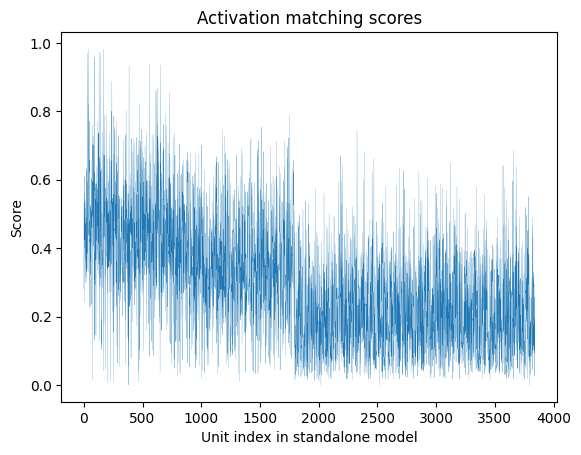

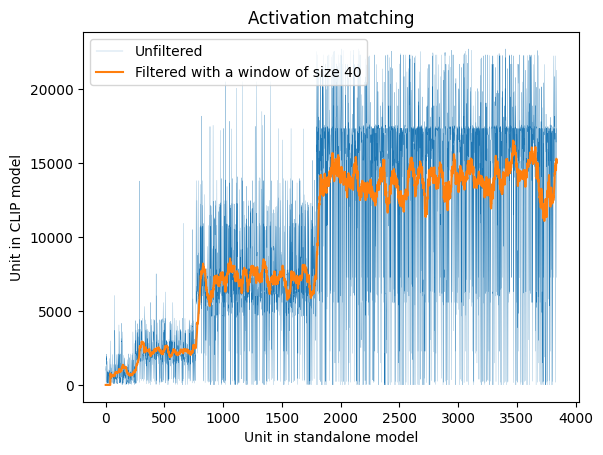

In [138]:
# plots
if True:
    plt.plot(match_scores.cpu().numpy(), linewidth=.15)
    plt.title("Activation matching scores")
    plt.xlabel("Unit index in standalone model")
    plt.ylabel("Score")
    plt.show()

    plt.plot(standalone_idxs.cpu().numpy(), label='Unfiltered', linewidth=.15)
    plt.plot(averaged_signal, label=f'Filtered with a window of size {WINDOW}')
    plt.title("Activation matching")
    plt.xlabel("Unit in standalone model")
    plt.ylabel("Unit in CLIP model")
    plt.legend()
    plt.show()

# layer swapping

In [23]:
def find_act(act_num, net_dict):
    """
    Finding the index of the layer and the local index of a unit within that layer,
    if all kernels within a model are stacked and the absolut index of the unit is 
    given.
    """
    layers_list = list(net_dict)
    
    layer = 0
    counter = 0
    
    while act_num >= counter:
        layer += 1
        counter += net_dict[layers_list[layer - 1]]
        
    act = act_num-counter + net_dict[layers_list[layer - 1]]
    
    del layers_list
    torch.cuda.empty_cache()
    
    return (layer - 1), act

In [192]:
def resize_and_stack(curr_layer, table, clip_activs, standalone_activs, all_standalone_layers, idxs, k):
    """
    Resize kernels from standalone model to the size of the kernels in clip model.
    
    resize_and_stack is invoked for every CLIP layer once.
    
    curr_layer                # index of CLIP layer
    table                     # matching scores 22'720x3'840
    clip_activs[i],           # CLIP activations [1, 256, 56, 56] of CLIP layer i (1 denotes the one and only image in this batch)
    standalone_activs,        # list of all standalone activations 49 x [1, #kernels, kernelheight, kernelwidth]
    all_standalone_layers,    # dict of standalone layers with activations as keys and #kernels in layers as values
    match_idxs,               # standalone kernel indexes (with highest scores) to be swapped with kernels in CLIP layer i
    k = 0)                    # not used! Will be computed in this function. (Replace all units of a layer)
    """
    
    # scores = match_scores[idxs]
    map_size = clip_activs.shape[2] # kernelwidth/kernelheight -> is equal to clip_activs.shape[3]
    standalone_activ_matches = torch.zeros_like(clip_activs)
    
    for i, idx in enumerate(idxs):
        clip_act_name = find_act(idx, all_standalone_layers)                                            # find layer and unit of this standalone unit to be swapped to CLIP
        activ = standalone_activs[clip_act_name[0]][:, clip_act_name[1], :, :].unsqueeze(0)             # activations of unit to be swapped
        activ = torch.nn.functional.interpolate(activ, size = (map_size, map_size), mode = "bicubic")   # upscale
        standalone_activ_matches[:, i, :, :] = activ
    
    #TODO maybe useless? Compare original idxs=match_idxs and the idxs at the end of this section!
    scores = torch.einsum('aixy,aixy->ai', clip_activs, standalone_activ_matches) / (map_size**2)
    k = standalone_activ_matches.shape[1]
    vals, idxs = torch.topk(-1*scores, k=k)
    
    print("CLIP layer" + str(curr_layer) + ": Replace " + str(k) + " units.")
    
    return standalone_activ_matches, idxs

In [193]:
def swap_activs(clip_model, cliplayer_name, standalone_activ, idx, clip_stats):
    """
    Use standalone layers to adapt clip layers.
    """
    def edit_rule(data, model):
        data[:, idx, :, :] = ((standalone_activ[:, idx, :, :].float()*clip_stats[1][:, idx, :, :])+ clip_stats[0][:, idx, :, :]).float()
        return data
    
    clip_model.edit_layer(cliplayer_name, edit_rule)

In [194]:
def compute_similarities(model_clip, image, text_features, logfile, similarities):
    """
    Compute CLIP cosine similarities.
    """
    
    # compute CLIP similarities
    with torch.no_grad():
        image_features = model_clip.model.encode_image(image.to(device))
        image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

    # log similarities (for debugging)
    with open(logfile, "a") as f:
        f.write("{}, {}, {}, {},\n".format(similarity[0].item(),
                                            similarity[1].item(),
                                            similarity[2].item(),
                                            similarity[3].item()))

    # save similarities
    similarities = np.hstack((similarities, similarity)) if similarities.size else similarity
    return similarities

In [195]:
def swap_layers(img, table, standalone_model, standalone_layers, clip_model, clip_layers, standalone_statistics, clip_statistics, match_list, texts):
    """
    Computes the CLIP cosine similarities after each swap of a layer in the CLIP model.
    Returns the original image (Used to compute the activations) and a list of CLIP cosine
    similarities after every swap. (Original CLIP cosine similarities before any swap
    at index 0)
    """
    # delete existing log-file
    LOGFILE_SWAPPING = "swapping.log"
    os.system(f"rm {LOGFILE_SWAPPING}")
    
    # local variables
    similarities = np.array([])
    
    # inference
    _ = standalone_model(img)
    _ = clip_model.model.encode_image(img)
    
    # capture activations
    standalone_activs = store_activs(standalone_model, standalone_layers)
    all_standalone_layers = dict_layers(standalone_activs)
    clip_activs = store_activs(clip_model, clip_layers)
    all_clip_layers = dict_layers(clip_activs)
    
    # normalize activations
    eps = 0.00001
    
    for i,_ in enumerate(standalone_activs):
        standalone_activs[i] = (standalone_activs[i] - standalone_statistics[i][0])/(standalone_statistics[i][1] + eps)
    
    for i,_ in enumerate(clip_activs):
        clip_activs[i] = (clip_activs[i] - clip_statistics[i][0]) / (clip_statistics[i][1] + eps)
    
    # generate text embedding
    with torch.no_grad():
        text_features = clip_model.model.encode_text(clip.tokenize(texts).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
    # initial CLIP cosine similarities
    similarities = compute_similarities(clip_model, img, text_features, LOGFILE_SWAPPING, similarities)
    
    # swap layers
    if True:
        j = 0 #j keeps track of activation
        for i, _ in enumerate(clip_activs): # i iterates over CLIP layers
            match_idxs = match_list[j:j + clip_activs[i].shape[1]] # slice of kernels (with highest scores between CLIP and standalone) for layer i
            j += clip_activs[i].shape[1] # add number of kernels in layer i; j holds number of kernels in layer i
            
            print(f"{i=} and {j=}")
            
            if True:
                # resize kernel sizes
                standalone_swaps, idxs = resize_and_stack(i,                        # index of CLIP layer
                                                          table,                    # matching scores 22'720x3'840
                                                          clip_activs[i],           # CLIP activations [1, 256, 56, 56] of CLIP layer i
                                                          standalone_activs,        # list of all standalone activations 49 x [1, #kernels, kernelheight, kernelwidth]
                                                          all_standalone_layers,    # dict of standalone layers with activations as keys and #kernels in layers as values
                                                          match_idxs,               # standalone kernel indexes (with highest scores) to be swapped with kernels in CLIP layer i
                                                          k = 0)                    # not used!

            if True:
                # update model
                swap_activs(clip_model, clip_layers[i], standalone_swaps, idxs, clip_statistics[i])        

            if True:
                # compute CLIP similarities
                similarities = compute_similarities(clip_model, img, text_features, LOGFILE_SWAPPING, similarities)

    # plot similarities over time
    return img, similarities

In [196]:
# sample image
data = next(iter(data_loader))
image = data[0][0].unsqueeze(dim=0).to(device)
label = data[1][0].item()

In [197]:
print(f"{image.device=}")
print(f"{table.device=}")
# print(f"{standalone_model.model.device=}")
# print(f"{standalone_layers.device=}")
# print(f"{clip_model.device=}")
# print(f"{clip_layers.device=}")
# print(f"{standalone_statistics.device=}")
# print(f"{clip_statistics.device=}")
print(f"{standalone_idxs.device=}")
# print(f"{captions.device=}")

image.device=device(type='cuda', index=0)
table.device=device(type='cuda', index=0)
standalone_idxs.device=device(type='cuda', index=0)


In [190]:
# setup captions
captions = ["a photo of a digit with the value 5.",
            "a photo of a digit with the value 8.",
            "a photo of a green digit.",
            "a photo of a red digit."]

# restore CLIP model
clip_model, clip_preprocess, clip_layers = setup_clip(USE_ALL_CLIP_LAYERS,
                                                      LIMIT_NR_LAYERS,
                                                      print_config=True)

# image = image.cpu()
# table = table.cpu()
# standalone_model = standalone_model.cpu()
# # standalone_layers = standalone_layers.cpu()
# clip_model = clip_model.cpu()
# # clip_layers = clip_layers.cpu()
# # standalone_statistics = standalone_statistics.cpu()
# # clip_statistics = clip_statistics.cpu()
# standalone_idxs = standalone_idxs.cpu()
# # captions = captions.cpu()

# swap layers (epoch 0 demonstrates the original CLIP output without any swapping)
# return
if True:
    img, cos_sim = swap_layers(image, table,
                               standalone_model, standalone_layers,
                               clip_model, clip_layers,
                               standalone_statistics, clip_statistics,
                               standalone_idxs, captions)

Number of CLIP layers: 4
['visual.layer1', 'visual.layer2', 'visual.layer3', 'visual.layer4']
i=0 and j=256
Layer0: Replace 256 out of 256 units
i=1 and j=768
Layer1: Replace 512 out of 512 units
i=2 and j=1792
Layer2: Replace 1024 out of 1024 units
i=3 and j=3840
Layer3: Replace 2048 out of 2048 units


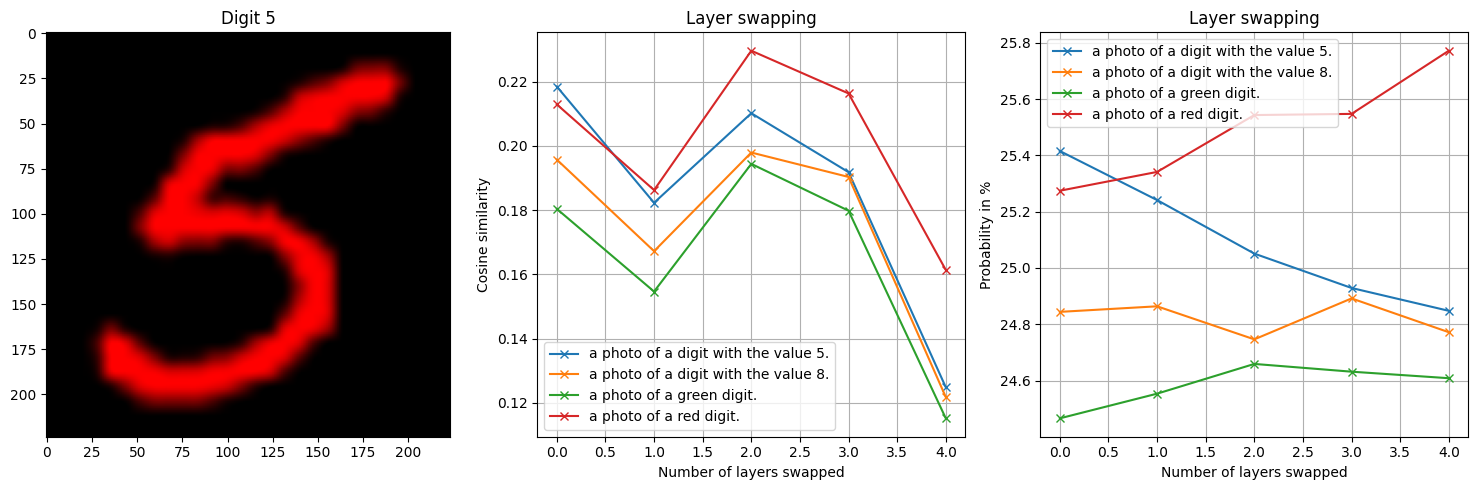

In [191]:
def display_layer_swapping_progress(img, cosine_similarities, labels, show_figure=["cosine similarities", "probabilites"]):
    """
    Display image, cosine similarity and class probabilities over the number of swapped layers.
    """
    
    # sanity check for valid figure names
    for figure_name in show_figure:
        if figure_name not in ["cosine similarities", "probabilites"]:
            raise Exception("Invalid figure name!")
    
    # sanity check to show at least one figure next to the image
    if len(show_figure) < 1:
        raise Exception("Need to display either cosine similarity or probabilies!")
    
    # show original image
    fig, axs = plt.subplots(1, 1+len(show_figure), figsize=(15, 5))
    axs[0].imshow(img)
    axs[0].set_title(f"Digit {label}")

    # show selected figures
    for i, figure_name in enumerate(show_figure):
        i += 1
        
        if figure_name == "cosine similarities":
            axs[i].plot(cosine_similarities, 'x-', label=labels)
            axs[i].set_title("Layer swapping")
            axs[i].set_xlabel("Number of layers swapped")
            axs[i].set_ylabel("Cosine similarity")
            axs[i].legend()
            axs[i].grid()

        if figure_name == "probabilites":
            axs[i].plot(100.0 * torch.tensor(cosine_similarities, dtype=torch.float32).softmax(dim=1), 'x-', label=labels)
            axs[i].set_title("Layer swapping")
            axs[i].set_xlabel("Number of layers swapped")
            axs[i].set_ylabel("Probability in %")
            axs[i].legend()
            axs[i].grid()

    plt.tight_layout()
    plt.show()

display_layer_swapping_progress(clip_preprocess_inverse(img.cpu(), clip_preprocess),
                                cos_sim.T,
                                captions,
                                show_figure=["cosine similarities", "probabilites"])